In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

### load packages

In [4]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [6]:
from tensorflow.keras.datasets import mnist

In [7]:
# load dataset
(train_images, Y_train), (test_images, Y_test) = mnist.load_data()
X_train = (train_images/255.).astype('float32')
X_test = (test_images/255.).astype('float32')
X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

# subset a validation set
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

# flatten X
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
X_valid_flat= X_valid.reshape((len(X_valid), np.product(np.shape(X_valid)[1:])))
print(len(X_train), len(X_valid), len(X_test))

50000 10000 10000


### define networks

In [8]:
dims = (28,28,1)
n_components = 64

In [9]:
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    ),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])

In [10]:
decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_components)),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=7 * 7 * 256, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 256)),
    tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    )
])

### Create model and train

In [11]:
embedder = tfUMAP(
    direct_embedding=False,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=5,
    encoder=encoder,
    decoding_method="network", 
    decoder=decoder,
    valid_X = X_valid,
    valid_Y = Y_valid,
    dims = dims
)

In [12]:
z = embedder.fit_transform(X_train_flat)

tfUMAP(decoder=<tensorflow.python.keras.engine.sequential.Sequential object at 0x7fa3702cb7f0>,
       decoding_method='network', dims=(28, 28, 1),
       encoder=<tensorflow.python.keras.engine.sequential.Sequential object at 0x7fa36fa45b00>,
       negative_sample_rate=5,
       optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fa36fa539e8>,
       tensorboard_logdir='/tmp/tensorboard/20200716-132306', training_epochs=5,
       valid_X=array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
       valid_Y=array([3, 8, 6, ..., 5, 6, 8], dtype=uint8))
Construct fuzzy simplicial set
Thu Jul 16 13:23:07 2020 Finding Nearest Neighbors
Thu Jul 16 13:23:07 2020 Building RP forest with 16 trees
Thu Jul 16 13:23:09 2020 parallel NN descent for 16 iterations
	 0  /  16
	 1  /

Thu Jul 16 15:12:13 2020 Finished embedding


### Plot model output

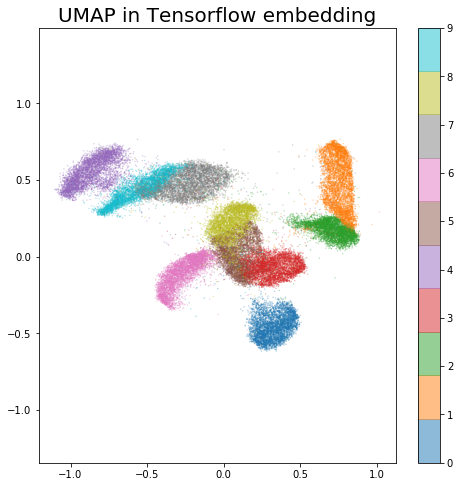

In [13]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [14]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

In [15]:
loss_df = retrieve_tensors(embedder.tensorboard_logdir)
loss_df[:3]

['umap_loss', 'recon_loss']
['recon_loss']


,wall_time,step,val,group,variable
0,1.594931e+09,1,1.851370,train,umap_loss
1,1.594931e+09,2,1.222166,train,umap_loss
2,1.594931e+09,3,0.903003,train,umap_loss


In [16]:
loss_df.group.unique()

array(['train', 'valid'], dtype=object)

Text(0.5, 1.0, 'Reconstruction loss')

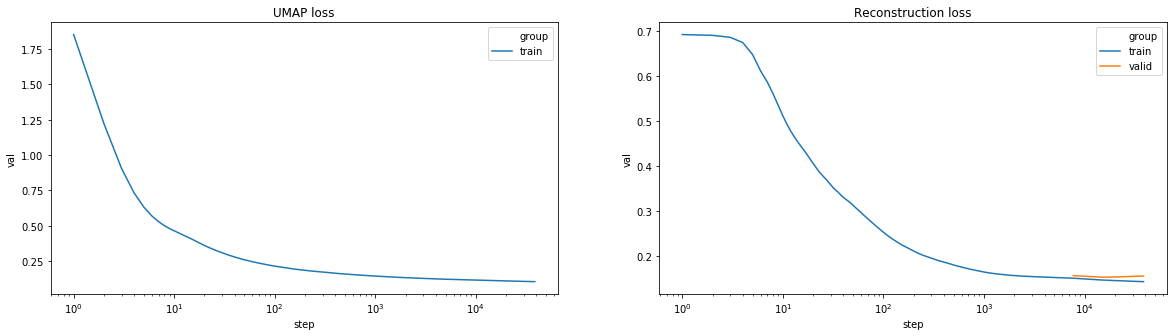

In [17]:
fig, axs = plt.subplots(ncols=2, figsize=(20,5))
ax = axs[0]
sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='umap_loss'], ax = ax)
ax.set_xscale('log')
ax.set_title('UMAP loss')

ax = axs[1]
sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='recon_loss'], ax = ax)
ax.set_xscale('log')
ax.set_title('Reconstruction loss')

### Save output

In [18]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [19]:
output_dir = MODEL_DIR/'projections'/ 'mnist' / '64'/ 'recon-network'
ensure_dir(output_dir)

In [20]:
embedder.save(output_dir)

Pickle of model saved


W0716 15:12:53.275960 140343940101952 deprecation.py:506] From /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
I0716 15:12:53.377113 140343940101952 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/mnist/64/recon-network/encoder/assets


Encoder Keras model saved


I0716 15:12:54.031994 140343940101952 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/mnist/64/recon-network/decoder/assets


Decoder Keras model saved


In [21]:
loss_df.to_pickle(output_dir / 'loss_df.pickle')

In [22]:
np.save(output_dir / 'z.npy', z)

### View reconstructions on test data

In [23]:
z_test = embedder.transform(X_test)

In [24]:
X_test_recon = embedder.inverse_transform(z_test)

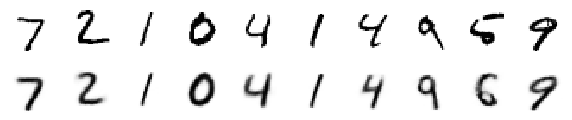

In [25]:
nex = 10
fig, axs = plt.subplots(ncols=nex, nrows=2, figsize=(nex,2))
for i in range(nex):
    axs[0,i].matshow(X_test[i].reshape(28,28), cmap='Greys')
    axs[1,i].matshow(X_test_recon[i].reshape(28,28), cmap="Greys")
for ax in axs.flatten():
    ax.axis('off')